Initial Burning Period
Training Start
Episode  100
Episode  200
Episode  300
Episode  400
Episode  500
Episode  600
Episode  700
Episode  800
Episode  900
Episode  1000
Episode  1100
Episode  1200
Episode  1300
Episode  1400
Episode  1500
Episode  1600
Episode  1700
Episode  1800
Episode  1900
Episode  2000
Episode  2100
Episode  2200
Episode  2300
Episode  2400
Episode  2500
Episode  2600
Episode  2700
Episode  2800
Episode  2900
Episode  3000
Episode  3100
Episode  3200
Episode  3300
Episode  3400
Episode  3500
Episode  3600
Episode  3700
Episode  3800
Episode  3900
Episode  4000
Episode  4100
Episode  4200
Episode  4300
Episode  4400
Episode  4500
Episode  4600
Episode  4700
Episode  4800
Episode  4900
Episode  5000
Episode  5100
Episode  5200
Episode  5300
Episode  5400
Episode  5500
Episode  5600
Episode  5700
Episode  5800
Episode  5900
Episode  6000
Episode  6100
Episode  6200
Episode  6300
Episode  6400
Episode  6500
Episode  6600
Episode  6700
Episode  6800
Episode  6900
Episo

0.99675


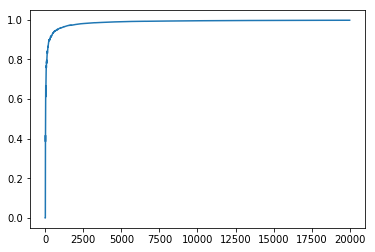

update_title_pos
update_title_pos
update_title_pos
update_title_pos


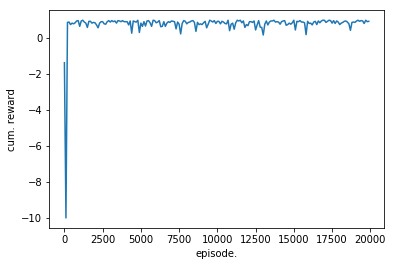

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import logging
import threading
from collections import deque, namedtuple

from dqn_env import ENVIRONMENT
from dqn_ops import one_hot_encode, variable_copy 
from dqn_q_net import QNet

# this line is not needed in py file
%matplotlib inline
# this line is not needed in py file

np.random.seed(0)
random.seed(0)
tf.random.set_random_seed(0) 

logging.basicConfig(level=logging.DEBUG, format='%(message)s')

""" Hyper Parameters """
gamma = 0.99
max_episodes = 20000
memory_size = 1000
num_burning_episode = 100
batch_size = 32
copy_period = 100
test_period = 100
epsilon_test = 0.00

""" Environment """
env = ENVIRONMENT()
exp = namedtuple('experience', ['state', 'action', 'reward', 'next_state', 'done'])

" Train-Queue "
train_q = tf.FIFOQueue(capacity=batch_size*4, \
                       #      ['state',   'action', 'reward',   'next_state', 'done']
                       dtypes=[tf.float32, tf.int32, tf.float32, tf.float32, tf.bool], \
                       shapes=[(env.num_states,), (), (1,), (env.num_states,), (1,)], \
                       # shapes=[[env.num_states], [], [1], [env.num_states], [1]], \
                       name='train_queue')

" Inputs Placeholder "
state_holder = tf.placeholder(tf.float32, \
                              shape=[None, env.num_states], \
                              name='state_holder')
action_holder = tf.placeholder(tf.int32, \
                               shape=[None], \
                               name='action_holder')
reward_holder = tf.placeholder(tf.float32, \
                               shape=[None, 1], \
                               name='reward_holder')
next_state_holder = tf.placeholder(tf.float32, \
                                   shape=[None, env.num_states], \
                                   name='next_state_holder')
done_holder = tf.placeholder(tf.bool, \
                             shape=[None, 1], \
                             name='state_holder')

lr_rate = tf.placeholder(dtype=tf.float32, \
                         shape=[], \
                         name='lr_rate')

state_holder_explore = tf.placeholder(tf.float32, \
                                      shape=[None, env.num_states], \
                                      name='state_holder_explore')

" Queue Ops "
enqueue_op = train_q.enqueue_many([state_holder, \
                                   action_holder, \
                                   reward_holder, \
                                   next_state_holder, \
                                   done_holder])
states, actions, rewards, next_states, dones = train_q.dequeue_many(batch_size)
q_close = train_q.close(cancel_pending_enqueues=True)

""" Q-net and target Q-net """
# this is computation steps using W in numpy implemenation.
# during training we allow the backpropagation to pass this block
# by setting
# train_ops = opt.minimize(q_loss, \
#                          var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, \
#                                                     Qnet.name))
with tf.variable_scope('qnet') as scope:
    Qnet = QNet(num_states=env.num_states, \
                num_actions=env.num_actions, \
                name=scope.name) # scope.name = 'qnet' 
    qnet = Qnet(states)
    qnet_explore = Qnet(state_holder_explore, reuse=True)
    greedy_action = tf.argmax(qnet_explore, axis=1)[0]

# check variable names
# print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
# [<tf.Variable 'qnet/weight1:0' shape=(11, 4) dtype=float32_ref>]

# this is computation steps using W_target in numpy implemenation.
# during training we block the backpropagation to pass this block
# by setting
# train_ops = opt.minimize(q_loss, \
#                          var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, \
#                                                     Qnet.name))
with tf.variable_scope('target_qnet') as scope:
    Qnet_target = QNet(num_states=env.num_states, \
                       num_actions=env.num_actions, \
                       name=scope.name) # scope.name = 'target_qnet' 
    qnet_target = Qnet_target(next_states)
    qnet_target_max = tf.reduce_max(qnet_target, axis=1, keepdims=True)
    
# check variable names
# print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
# [<tf.Variable 'qnet/weight1:0' shape=(11, 4) dtype=float32_ref>, 
# <tf.Variable 'target_qnet/weight1:0' shape=(11, 4) dtype=float32_ref>]
#
# https://stackoverflow.com/questions/37958706/in-tensorflow-what-is-the-difference-between-a-tensor-that-has-a-type-ending-in
#
# In Tensorflow, what is the difference between 
# a tensor that has a type ending in _ref and a tensor that does not?
# A reference-typed tensor is mutable. 
# The most common way to create a reference-typed tensor is to define a tf.Variable: 
# defining a tf.Variable whose initial value has dtype tf.float32 
# will create a reference-typed tensor with dtype tf.float32_ref.

""" Variables Copy Operation """
# we run this copy_ops periodically
# to do W_target = deepcopy(W) in numpy implemenation
copy_ops = variable_copy(from_scope=Qnet.name, to_scope=Qnet_target.name)

""" Q-target """
# q_target is like a label in the supervised learing
# so that it is fixed during training.
# that is why we block the backpropagation using tf.stop_gradient 
q_target = tf.stop_gradient(
    (1.0 - tf.to_float(dones)) * (rewards + gamma * qnet_target_max) \
    + tf.to_float(dones) * rewards)
# q_target = tf.stop_gradient(rewards + gamma * qnet_target_max)

""" Loss & Training Operations"""
q_sa = tf.reduce_sum(qnet * tf.one_hot(actions, env.num_actions, dtype=tf.float32), \
                     axis=1, \
                     keepdims=True)
q_loss = tf.reduce_mean(tf.square(q_sa - q_target))
opt = tf.train.GradientDescentOptimizer(learning_rate=lr_rate)
train_ops = opt.minimize(q_loss, \
                         var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, \
                                                    Qnet.name))
# # checker code
# print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
# print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, Qnet.name))
# print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, Qnet_target.name))

" Variable Initializer"
init_ops = tf.global_variables_initializer()

""" Replay Memory"""
replay_memory = deque(maxlen=memory_size)

""" Burning Period """
logging.info('Initial Burning Period')
for i in range(num_burning_episode):
    
    env.current_state, env.done = env.reset()
    
    while not env.done:
        action = env.random_action() # this is random action
        env.reward, next_state, env.done, _, _ = env.step(action)

        sample = exp(state=env.current_state, \
                     action=action, \
                     reward=env.reward, \
                     next_state=next_state, \
                     done=env.done)
        replay_memory.append(sample)

        env.current_state = next_state
                
class SampleEnquer(threading.Thread):
    def __init__(self, sess):
        super().__init__()
        self._sess = sess

    def run(self):
        
        while_breaker = False
        while not while_breaker:
        
            # Sample scenarios from replay-memory.
            # samples = [sample1, sample2, ... , sample32]
            samples = random.sample(replay_memory, batch_size) 

            states_ = [sample.state for sample in samples]
            actions_ = [sample.action for sample in samples]
            rewards_ = [sample.reward for sample in samples]
            next_states_ = [sample.next_state for sample in samples]
            dones_ = [sample.done for sample in samples]

            states = one_hot_encode(states_, env.num_states)
            actions = np.array(actions_, dtype=np.int32)
            rewards = np.reshape(np.array(rewards_, dtype=np.float32), [-1, 1])
            next_states = one_hot_encode(next_states_, env.num_states)
            dones = np.reshape(np.array(dones_, dtype=np.float32), [-1, 1])

            try:
                self._sess.run(enqueue_op, feed_dict={state_holder: states,
                                                action_holder: actions,
                                                reward_holder: rewards,
                                                next_state_holder: next_states,
                                                done_holder: dones})
            except Exception:
                while_breaker = True

    def stop(self):
        self._sess.run(q_close)
        
sess = tf.Session()
sess.run(init_ops)

""" Training """
logging.info('Training Start')
train_step = 0
cum_return_test = []
step_history = []

# https://www.python-course.eu/threads.php
# The class threading.Thread has a method start(), 
# which can start a Thread. 
# It triggers off the method run(), which has to be overloaded. 
# The join() method makes sure that the main program waits 
# until all threads have terminated. 
sample_enquer = SampleEnquer(sess)
sample_enquer.start()

for episode_num in range(max_episodes):
    
    # Reset Environment and Reset Cum. Reward
    env.current_state, env.done = env.reset()
        
    learning_rate = 1. / ((episode_num * 0.1) + 1.)
    epsilon = 1. / ((episode_num * 0.1) + 1.)

    while not env.done:
        
        # Action Selection
        if np.random.uniform(0.,1.) > epsilon:
            action = sess.run(greedy_action,
                              feed_dict={state_holder_explore: \
                                         one_hot_encode([env.current_state], \
                                                        env.num_states)})
        else:
            action = env.random_action() # random action
        
        env.reward, next_state, env.done, _, _ = env.step(action)

        sample = exp(state=env.current_state, \
                     action=action, \
                     reward=env.reward, \
                     next_state=next_state, \
                     done=env.done)
        replay_memory.append(sample)
        
        env.current_state = next_state
        
        # activate this line: states, ... = train_q.dequeue_many(batch_size)
        sess.run(train_ops, feed_dict={lr_rate: learning_rate}) 

        train_step += 1

        # Network Synchronization
        if train_step % copy_period == 0:
            sess.run(copy_ops)

        # Terminal of Scenario.
        if env.done:
            if env.current_state == env.win_state:
                step_history.append(1)
            if env.current_state == env.lose_state:
                step_history.append(0)
            break

    if (episode_num + 1) % 100 == 0:
        logging.info('Episode  %d' % (episode_num + 1))

    """ Test """
    if episode_num % test_period == 0:
        env.current_state, env.done = env.reset()
        cum_rwd = 0.0

        while not env.done:
            
            # Action Selection
            if np.random.uniform(0.,1.) > epsilon_test:
                action = sess.run(greedy_action, \
                                  feed_dict={state_holder_explore: \
                                             one_hot_encode([env.current_state], \
                                                            env.num_states)})
            else:
                action = env.random_action() # random action
                
            env.reward, next_state, env.done, _, _ = env.step(action)
            cum_rwd += env.reward
            
            if cum_rwd < -10.:
                break

            env.current_state = next_state

        cum_return_test.append(cum_rwd)
        
# Stop sending samles from replay_memory to GPU
sample_enquer.stop()
sample_enquer.join()

fig = plt.figure(1)
history = np.cumsum(step_history) / (np.arange(max_episodes) + 1)
print(history[-1])
plt.plot(history)
plt.show()

fig = plt.figure(2)
plt.plot(np.arange(len(cum_return_test)) * test_period, cum_return_test)
plt.xlabel('episode.')
plt.ylabel('cum. reward')
plt.show()